In [1]:
# Cell 0: Setup
!pip install -q torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1
!pip install -q tqdm

from google.colab import drive
drive.mount('/content/drive')  # follow prompt to mount your Drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 788.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176

In [2]:
# Cell 1
import os, random, math, time, json
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# reproducibility
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cpu


In [3]:
import os
os.environ["TORCHINDUCTOR_DISABLE"] = "1"  # make sure new runtime never loads Triton


In [4]:
# Cell 2: point this to your dataset file
DATA_PATH = "/content/drive/MyDrive/dataset/Pride_and_Prejudice-Jane_Austen.txt"  # change if needed

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    text = f.read()

print("Dataset length (chars):", len(text))
print("First 1000 chars:\n", text[:1000])


Dataset length (chars): 711331
First 1000 chars:
 The Project Gutenberg eBook, Pride and Prejudice, by Jane Austen, Edited
by R. W. (Robert William) Chapman


This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org





Title: Pride and Prejudice


Author: Jane Austen

Editor: R. W. (Robert William) Chapman

Release Date: May 9, 2013  [eBook #42671]

Language: English


***START OF THE PROJECT GUTENBERG EBOOK PRIDE AND PREJUDICE***


E-text prepared by Greg Weeks, Jon Hurst, Mary Meehan, and the Online
Distributed Proofreading Team (http://www.pgdp.net) from page images
generously made available by Internet Archive (https://archive.org)



Note: Project Gutenberg also has an HTML version of this
      file which includes the original illustrations.
      See 42671-h.htm or 42671-h.zip:
      (htt

In [5]:
# Cell 3: Basic whitespace tokenizer + vocab build
def tokenize(text):
    return text.replace('\n', ' <eos> ').split()

tokens = tokenize(text)
print("Total tokens:", len(tokens))

# build vocab
MIN_FREQ = 1
counter = Counter(tokens)
vocab = ['<pad>', '<unk>'] + [w for w,f in counter.items() if f>=MIN_FREQ]
itos = vocab
stoi = {w:i for i,w in enumerate(itos)}
vocab_size = len(itos)
print("Vocab size:", vocab_size)

# helper converts
def tokens_to_ids(tokens):
    return [stoi.get(t, stoi['<unk>']) for t in tokens]
ids = tokens_to_ids(tokens)


Total tokens: 138682
Vocab size: 13780


In [6]:
# Cell 4: splits
N = len(ids)
train_frac, val_frac = 0.8, 0.1
n_train = int(N * train_frac)
n_val = int(N * val_frac)

train_ids = ids[:n_train]
val_ids = ids[n_train:n_train+n_val]
test_ids = ids[n_train+n_val:]

print(len(train_ids), len(val_ids), len(test_ids))


110945 13868 13869


In [7]:
# Cell 5: Dataset and collate
class LMDataset(Dataset):
    def __init__(self, ids, seq_len):
        self.ids = ids
        self.seq_len = seq_len
    def __len__(self):
        return max(0, len(self.ids) - self.seq_len)
    def __getitem__(self, idx):
        x = torch.tensor(self.ids[idx:idx+self.seq_len], dtype=torch.long)
        y = torch.tensor(self.ids[idx+1:idx+self.seq_len+1], dtype=torch.long)  # next token targets
        return x, y

def get_dataloader(ids, seq_len, batch_size, shuffle=True):
    ds = LMDataset(ids, seq_len)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=True)

# example
seq_len = 30
batch_size = 64
dl = get_dataloader(train_ids, seq_len, batch_size)
x,y = next(iter(dl))
print(x.shape, y.shape)


torch.Size([64, 30]) torch.Size([64, 30])


In [8]:
# Cell 6: LSTM language model
class LSTMLM(nn.Module):
    def __init__(self, vocab_size, emb_size=128, hidden_size=256, num_layers=2, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.lstm = nn.LSTM(emb_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x, hidden=None):
        emb = self.embedding(x)                 # (B, L, E)
        out, hidden = self.lstm(emb, hidden)    # out: (B, L, H)
        logits = self.fc(out)                   # (B, L, V)
        return logits, hidden

# sanity
model = LSTMLM(vocab_size).to(device)
print(model)


LSTMLM(
  (embedding): Embedding(13780, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=13780, bias=True)
)


In [9]:
# Cell 7: utilities
criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore pad token
def compute_perplexity(loss):
    return math.exp(loss) if loss < 100 else float('inf')

def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            logits, _ = model(xb)
            B,L,V = logits.shape
            loss = criterion(logits.view(B*L, V), yb.view(B*L))
            total_loss += loss.item() * (B*L)
            total_tokens += (B*L)
    return total_loss / total_tokens


In [10]:
# Cell 8: train loop (one function)
def train_model(model, train_dl, val_dl, epochs=10, lr=1e-3, clip=1.0, save_path=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []
    best_val = float('inf')
    for ep in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        total = 0
        for xb, yb in tqdm(train_dl, desc=f"Epoch {ep}"):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits, _ = model(xb)
            B,L,V = logits.shape
            loss = criterion(logits.view(B*L,V), yb.view(B*L))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            running_loss += loss.item() * (B*L)
            total += (B*L)
        train_loss = running_loss/total
        val_loss = evaluate(model, val_dl)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {ep}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_ppl={compute_perplexity(val_loss):.2f}")
        if val_loss < best_val:
            best_val = val_loss
            if save_path:
                torch.save(model.state_dict(), save_path)
    return train_losses, val_losses


In [11]:
# Cell 9: dataloaders (we'll create small subset for overfitting experiment)
seq_len = 30
batch_size = 64

train_dl = get_dataloader(train_ids, seq_len, batch_size, shuffle=True)
val_dl = get_dataloader(val_ids, seq_len, batch_size, shuffle=False)
test_dl = get_dataloader(test_ids, seq_len, batch_size, shuffle=False)


In [12]:
# Define plotting function (Cell 13 helper reused here)
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title="Loss Curves", save_path=None):
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    plt.show()


Epoch 1: 100%|██████████| 1733/1733 [15:37<00:00,  1.85it/s]


Epoch 1: train_loss=6.5542 val_loss=6.4941 val_ppl=661.21


Epoch 2: 100%|██████████| 1733/1733 [15:35<00:00,  1.85it/s]


Epoch 2: train_loss=5.8409 val_loss=6.2846 val_ppl=536.27


Epoch 3: 100%|██████████| 1733/1733 [15:38<00:00,  1.85it/s]


Epoch 3: train_loss=5.3831 val_loss=6.2445 val_ppl=515.15


Epoch 4: 100%|██████████| 1733/1733 [15:48<00:00,  1.83it/s]


Epoch 4: train_loss=5.0637 val_loss=6.2764 val_ppl=531.85


Epoch 5: 100%|██████████| 1733/1733 [15:34<00:00,  1.85it/s]


Epoch 5: train_loss=4.8070 val_loss=6.3119 val_ppl=551.09
Plot saved to /content/drive/MyDrive/dataset/underfit_loss.png


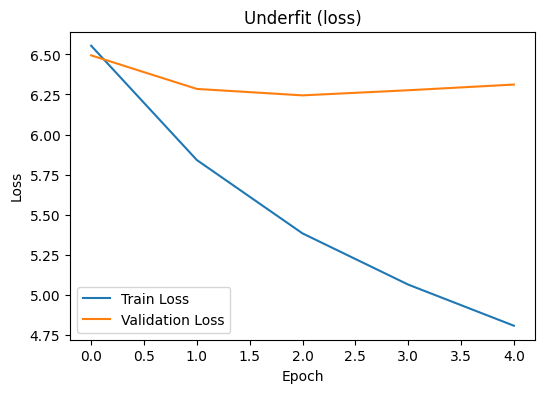

In [13]:
# Underfit

import os
os.environ["TORCHINDUCTOR_DISABLE"] = "1"

import torch
torch.backends.cuda.matmul.allow_tf32 = True

model_under = LSTMLM(
    vocab_size=vocab_size,
    emb_size=32,
    hidden_size=32,
    num_layers=1,
    dropout=0.0
).to(device)

save_dir = "/content/drive/MyDrive/dataset"
os.makedirs(save_dir, exist_ok=True)

train_losses_u, val_losses_u = train_model(
    model=model_under,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=5,
    lr=1e-3,
    save_path=f"{save_dir}/model_under.pth"
)

plot_losses(
    train_losses_u,
    val_losses_u,
    title="Underfit (loss)",
    save_path=f"{save_dir}/underfit_loss.png"
)


Epoch 1: 100%|██████████| 61/61 [01:48<00:00,  1.77s/it]


Epoch 1: train_loss=6.3181 val_loss=8.6442 val_ppl=5677.27


Epoch 2: 100%|██████████| 61/61 [01:42<00:00,  1.67s/it]


Epoch 2: train_loss=5.5650 val_loss=8.9462 val_ppl=7678.73


Epoch 3: 100%|██████████| 61/61 [01:41<00:00,  1.67s/it]


Epoch 3: train_loss=5.5392 val_loss=9.1047 val_ppl=8997.72


Epoch 4: 100%|██████████| 61/61 [01:40<00:00,  1.65s/it]


Epoch 4: train_loss=5.5281 val_loss=9.1603 val_ppl=9511.76


Epoch 5: 100%|██████████| 61/61 [01:41<00:00,  1.67s/it]


Epoch 5: train_loss=5.4448 val_loss=9.2602 val_ppl=10511.02


Epoch 6: 100%|██████████| 61/61 [01:42<00:00,  1.68s/it]


Epoch 6: train_loss=5.2205 val_loss=9.4697 val_ppl=12960.48


Epoch 7: 100%|██████████| 61/61 [01:40<00:00,  1.65s/it]


Epoch 7: train_loss=4.9876 val_loss=9.6972 val_ppl=16271.63


Epoch 8: 100%|██████████| 61/61 [01:40<00:00,  1.65s/it]


Epoch 8: train_loss=4.7515 val_loss=9.9552 val_ppl=21060.90


Epoch 9: 100%|██████████| 61/61 [01:41<00:00,  1.67s/it]


Epoch 9: train_loss=4.4968 val_loss=10.1377 val_ppl=25278.12


Epoch 10: 100%|██████████| 61/61 [01:41<00:00,  1.67s/it]


Epoch 10: train_loss=4.2255 val_loss=10.2716 val_ppl=28899.64


Epoch 11: 100%|██████████| 61/61 [01:41<00:00,  1.66s/it]


Epoch 11: train_loss=3.9563 val_loss=10.5200 val_ppl=37047.77


Epoch 12: 100%|██████████| 61/61 [01:42<00:00,  1.68s/it]


Epoch 12: train_loss=3.7005 val_loss=10.6231 val_ppl=41072.14


Epoch 13: 100%|██████████| 61/61 [01:41<00:00,  1.66s/it]


Epoch 13: train_loss=3.4142 val_loss=10.8282 val_ppl=50421.98


Epoch 14: 100%|██████████| 61/61 [01:41<00:00,  1.66s/it]


Epoch 14: train_loss=3.1139 val_loss=10.9631 val_ppl=57702.78


Epoch 15: 100%|██████████| 61/61 [01:43<00:00,  1.69s/it]


Epoch 15: train_loss=2.8148 val_loss=11.1841 val_ppl=71976.69
Plot saved to /content/drive/MyDrive/dataset/overfit_loss.png


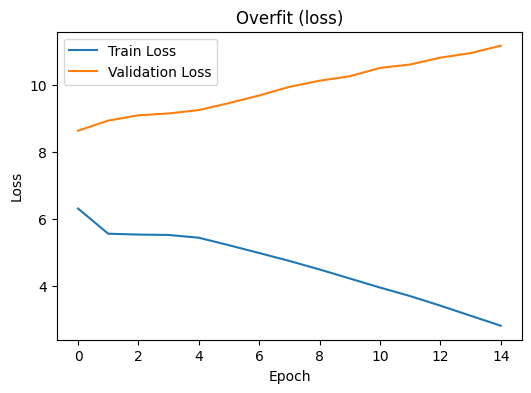


 Model and plot saved to: /content/drive/MyDrive/dataset
  - Model file: /content/drive/MyDrive/dataset/model_over.pth
  - Plot image: /content/drive/MyDrive/dataset/overfit_loss.png


In [14]:
# Cell 11: Overfit (small subset, Colab-safe + auto-save plot)

import os
os.environ["TORCHINDUCTOR_DISABLE"] = "1"   # disable buggy Triton compiler on Colab

# --- Create a small subset to intentionally overfit ---
small_train_ids = train_ids[:2000]   # tiny subset forces overfitting
seq_len = 30                         # sequence length
batch_size = 32

# Dataloader for small subset
small_train_dl = get_dataloader(small_train_ids, seq_len, batch_size, shuffle=True)

# --- Build a large model (more capacity = overfitting) ---
model_over = LSTMLM(
    vocab_size=vocab_size,
    emb_size=256,
    hidden_size=512,
    num_layers=3,
    dropout=0.0
).to(device)

# --- Ensure Drive folder exists for saving outputs ---
save_dir = "/content/drive/MyDrive/dataset"
os.makedirs(save_dir, exist_ok=True)

# --- Train model ---
train_losses_o, val_losses_o = train_model(
    model=model_over,
    train_dl=small_train_dl,
    val_dl=val_dl,
    epochs=15,                      # reduce to 15 if 20 is too long
    lr=5e-4,
    save_path=f"{save_dir}/model_over.pth"
)

# --- Plot and save training vs validation loss ---
plot_losses(
    train_losses_o,
    val_losses_o,
    title="Overfit (loss)",
    save_path=f"{save_dir}/overfit_loss.png"
)

print(f"\n Model and plot saved to: {save_dir}")
print(f"  - Model file: {save_dir}/model_over.pth")
print(f"  - Plot image: {save_dir}/overfit_loss.png")


Epoch 1: 100%|██████████| 467/467 [17:20<00:00,  2.23s/it]


Epoch 1: train_loss=6.5956 val_loss=7.1576 val_ppl=1283.77


Epoch 2: 100%|██████████| 467/467 [17:14<00:00,  2.22s/it]


Epoch 2: train_loss=6.3705 val_loss=7.2714 val_ppl=1438.60


Epoch 3: 100%|██████████| 467/467 [17:17<00:00,  2.22s/it]


Epoch 3: train_loss=6.2698 val_loss=7.2469 val_ppl=1403.77


Epoch 4: 100%|██████████| 467/467 [17:21<00:00,  2.23s/it]


Epoch 4: train_loss=6.0838 val_loss=7.1926 val_ppl=1329.55


Epoch 5: 100%|██████████| 467/467 [17:24<00:00,  2.24s/it]


Epoch 5: train_loss=5.9024 val_loss=7.1589 val_ppl=1285.46


Epoch 6: 100%|██████████| 467/467 [17:24<00:00,  2.24s/it]


Epoch 6: train_loss=5.7241 val_loss=7.1148 val_ppl=1230.02


Epoch 7: 100%|██████████| 467/467 [17:24<00:00,  2.24s/it]


Epoch 7: train_loss=5.5352 val_loss=7.1280 val_ppl=1246.38
Plot saved to /content/drive/MyDrive/dataset/bestfit_loss.png


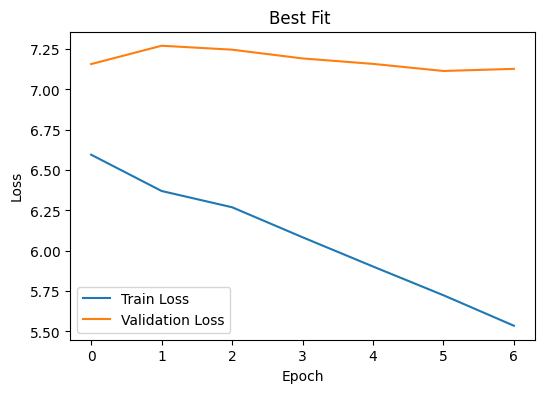

In [15]:
#  Best-Fit Training (combines Step 1 + Step 2)

# Use only a portion of the dataset for quicker training
train_ids_small = train_ids[:30000]   # roughly 25% of data
val_ids_small   = val_ids[:5000]      # small validation set

# Recreate dataloaders for smaller data
seq_len = 50          # slightly longer sequences reduce iterations
batch_size = 64       # balanced for T4 GPU

train_dl_small = get_dataloader(train_ids_small, seq_len, batch_size, shuffle=True)
val_dl_small   = get_dataloader(val_ids_small, seq_len, batch_size, shuffle=False)

# Build model (medium capacity = best-fit)
model_best = LSTMLM(
    vocab_size=vocab_size,
    emb_size=128,
    hidden_size=256,
    num_layers=2,
    dropout=0.3
).to(device)

# Train fewer epochs for faster completion
train_losses_b, val_losses_b = train_model(
    model=model_best,
    train_dl=train_dl_small,
    val_dl=val_dl_small,
    epochs=7,              # ⬅️ reduced from 15 → 7
    lr=3e-4,
    save_path="/content/drive/MyDrive/dataset/model_best.pth"
)

# Plot and save the loss curves
plot_losses(
    train_losses_b,
    val_losses_b,
    title="Best Fit ",
    save_path="/content/drive/MyDrive/dataset/bestfit_loss.png"
)


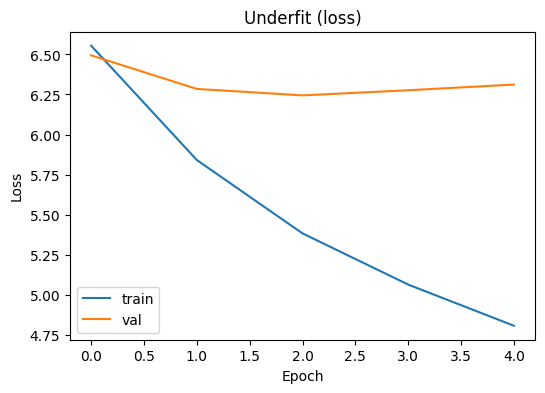

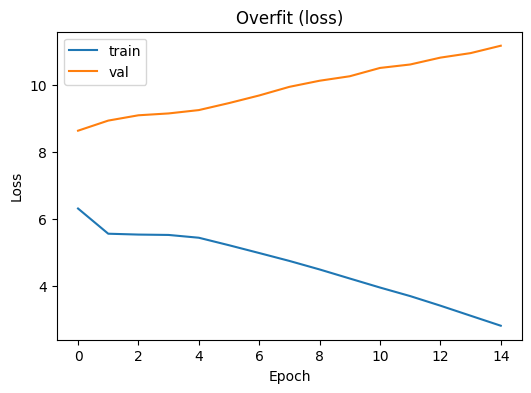

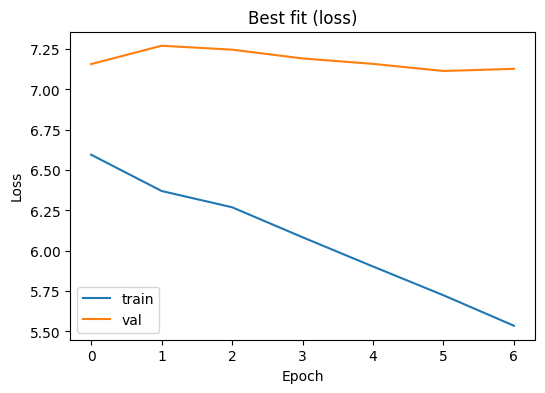

In [16]:
# Cell 13: plot helper
def plot_losses(train_losses, val_losses, title, save_path=None):
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

plot_losses(train_losses_u, val_losses_u, 'Underfit (loss)', '/content/drive/MyDrive/dataset/underfit_loss.png')
plot_losses(train_losses_o, val_losses_o, 'Overfit (loss)', '/content/drive/MyDrive/dataset/overfit_loss.png')
plot_losses(train_losses_b, val_losses_b, 'Best fit (loss)', '/content/drive/MyDrive/dataset/bestfit_loss.png')


In [17]:
# Cell 14
# load best model (saved during its run)
model_best_loaded = LSTMLM(vocab_size, emb_size=128, hidden_size=256, num_layers=2, dropout=0.3).to(device)
model_best_loaded.load_state_dict(torch.load("/content/drive/MyDrive/dataset/model_best.pth"))
test_loss = evaluate(model_best_loaded, test_dl)
print("Test Loss:", test_loss)
print("Test Perplexity:", compute_perplexity(test_loss))


Test Loss: 7.990081319102535
Test Perplexity: 2951.5369660624037


In [18]:
# Cell 15: save artifacts
os.makedirs('/content/drive/MyDrive/dataset/artifacts', exist_ok=True)
with open('/content/drive/MyDrive/dataset/artifacts/vocab.json', 'w', encoding='utf-8') as f:
    json.dump(itos, f)
results = {
    "underfit": {"train_losses": train_losses_u, "val_losses": val_losses_u},
    "overfit": {"train_losses": train_losses_o, "val_losses": val_losses_o},
    "best": {"train_losses": train_losses_b, "val_losses": val_losses_b, "test_loss": test_loss, "test_ppl": compute_perplexity(test_loss)}
}
with open('/content/drive/MyDrive/dataset/artifacts/results.json', 'w') as f:
    json.dump(results, f, indent=2)
print("Saved artifacts to Drive.")


Saved artifacts to Drive.


In [19]:
# Cell 16: greedy sampling
def generate_text(model, start_tokens, gen_len=50):
    model.eval()
    tokens = start_tokens[:]
    input_ids = torch.tensor([tokens], dtype=torch.long).to(device)
    hidden = None
    for _ in range(gen_len):
        logits, hidden = model(input_ids[:, -seq_len:], hidden)
        next_logits = logits[:, -1, :]
        probs = torch.softmax(next_logits, dim=-1)
        next_id = torch.argmax(probs, dim=-1).item()
        tokens.append(next_id)
        input_ids = torch.tensor([tokens], dtype=torch.long).to(device)
    return tokens

# test
vocab_loaded = itos
start_words = ['<eos>'] + tokens[:5]  # use first tokens as start
start_ids = tokens_to_ids(start_words)
out_ids = generate_text(model_best_loaded, start_ids, gen_len=40)
print(" ".join([vocab_loaded[i] for i in out_ids[:50]]))


<eos> The Project Gutenberg eBook, Pride of the <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
